# Usando Regressão Linear para Explicar a votação de Deputados

Antes de tudo, é necessário fazer import dos frameworks que serão utilizados de forma a auxiliar a análise e manipulação dos dados, mas também os frameworks responsáveis por fazer a regressão linear em si.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder as le
from scipy.stats import normaltest
from plotly import plotly
import plotly.graph_objs as go

In [ ]:
from sklearn.linear_model import Lasso, Ridge

## Import dos dados

Tentamos importar os dados a partir do Google Drive, já que está sendo feito no Google Colaboratory. Caso não seja possível, importa-se os dados a partir da pasta local.

In [2]:
try:
  drv = 'drive/My Drive/CDP/'
  treino = pd.read_csv(drv + 'train_cat.csv')
  teste = pd.read_csv(drv + 'test_cat.csv')
except:
  parent = '../datasets/'
  treino = pd.read_csv(parent + 'train.csv')
  teste = pd.read_csv(parent + 'test.csv')

## Análise dos dados
Como analisaremos os dados de treino, é necessário criar funções que sejam reutilizáveis, para permitir que o mesmo procedimento seja realizado em novas etapas do código. Inicialmente, analisaremos a distribuição das variáveis numéricas com a função `analisa_numericas`, aplicando a normalização nos casos necessários, vistos posteriormente.

Além dos gráficos, será feita uma verificação matemática para gerar um array no qual serão definidas as variáveis que devem ser normalizadas nos dados de treino e de teste: 
considera-se a hipótese de que o array segue uma distribuição normal e define-se um limite `alpha=0.0001` ; caso o resultado do teste de normalidade for menor que alpha, a hipótese de seguir a distribuição normal é rejeitada, isto é, os dados não seguem uma distribuição normal.

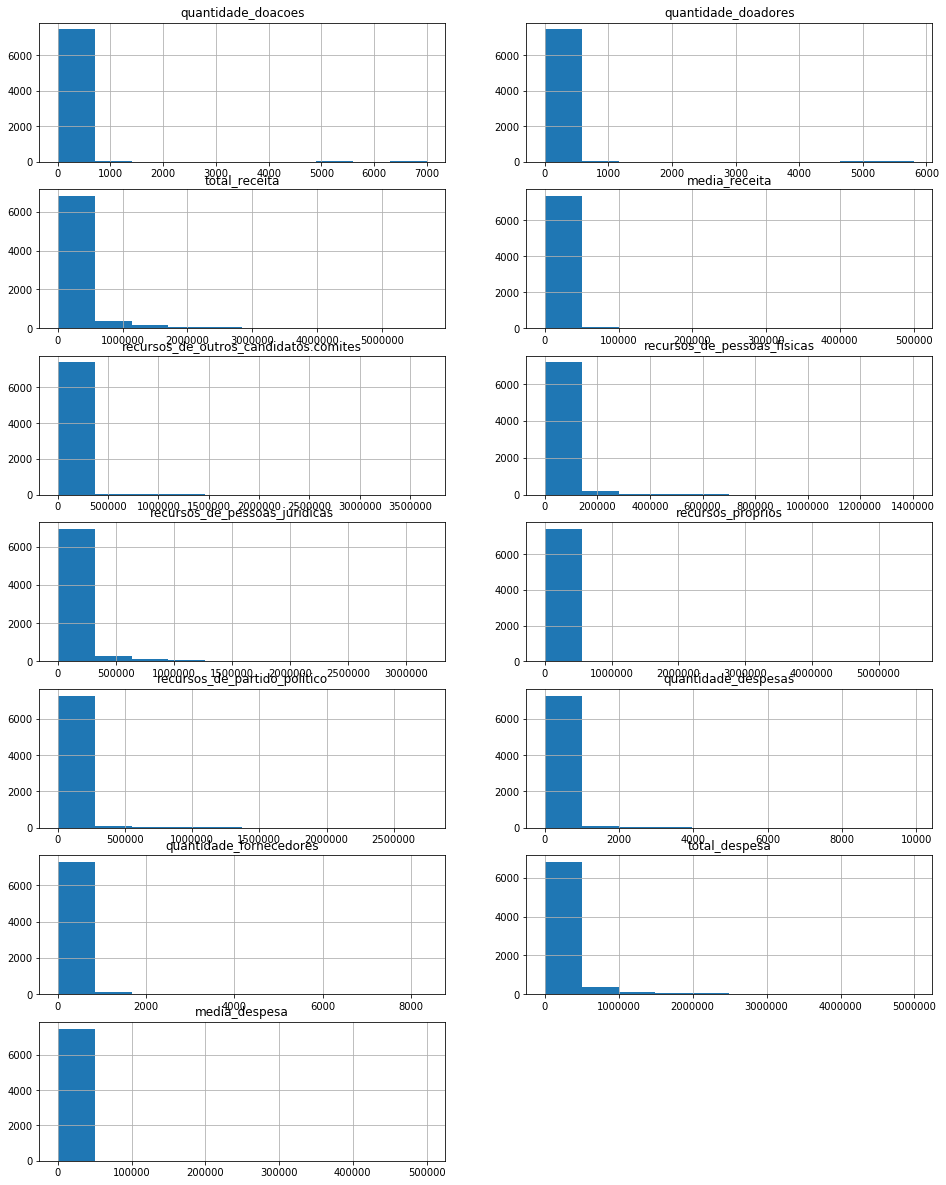

In [3]:
def is_numerico(coluna):
  valor = coluna.ravel()[0]
  numericos = [np.float64, np.float32, np.int64]
  for n in numericos:
    if isinstance(valor, n):
      return True
  return False
  
  
def analisa_numericas(df):
  plt.figure(figsize=(16,24))
  plt.title('Análise das variáveis')

  col_numericas = []
  col_nao_normais = []
  alpha = 1e-3
  
  for coluna in list(df):
    if is_numerico(df[coluna]) and coluna != "ano" and coluna != "sequencial_candidato" and coluna != "votos":
      col_numericas.append(coluna)
      if normaltest(df[coluna])[1] < alpha:
        col_nao_normais.append(coluna)
        
  for i in range(len(col_numericas)):
    coluna = col_numericas[i]
    plt.subplot(round(len(col_numericas)/2.0)+1, 2, i+1)
    plt.title(coluna)
    df[coluna].hist()
  plt.show()
  
  return col_nao_normais
  
colunas = analisa_numericas(treino)

## Manipulação dos Dados

A partir da análise dos gráficos acima, podemos identificar as colunas numéricas que possuem seus dados normalizados, e por isso criaremos a função `normaliza_dados`,  que normaliza todas as colunas recebidas e, ao fim, repete a análise gráfica feita acima.

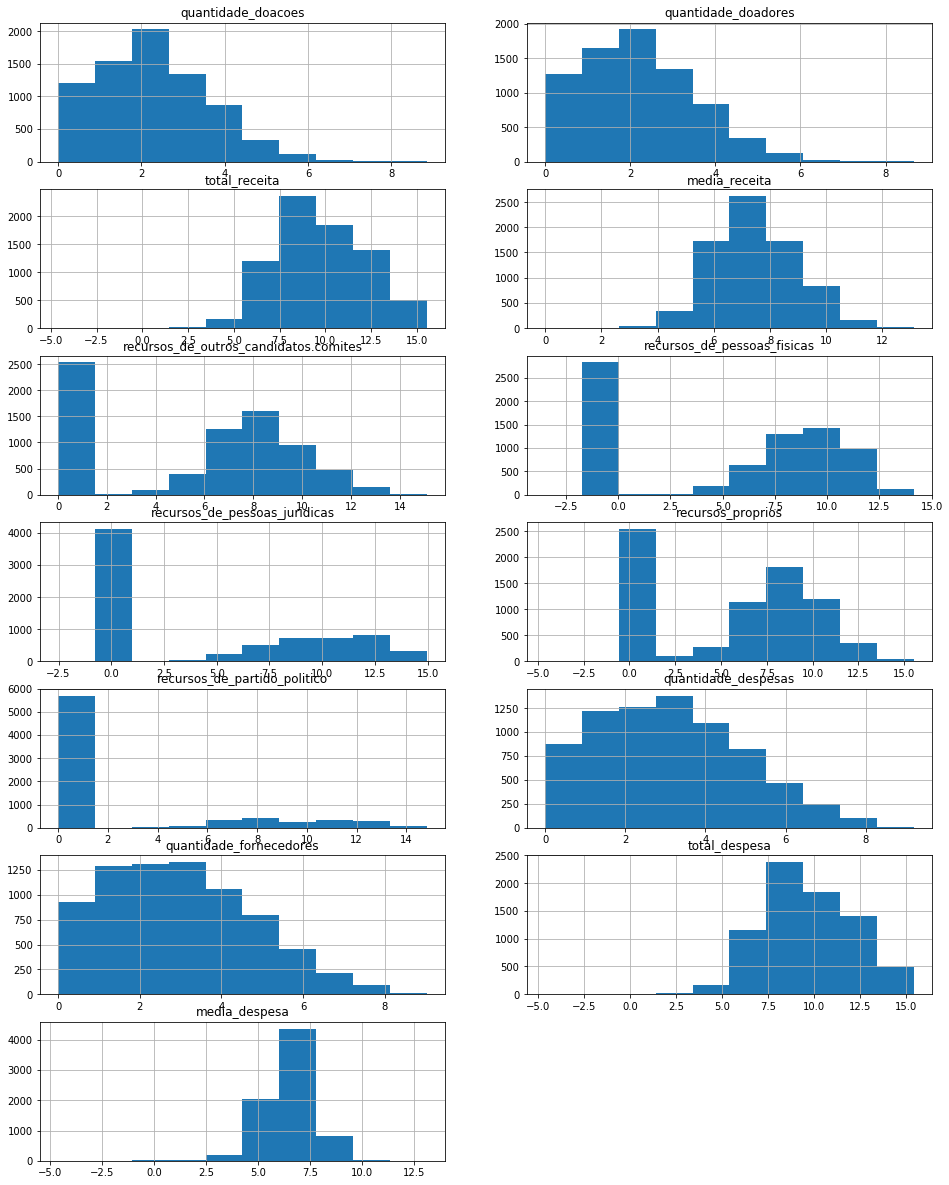

In [4]:
def normaliza_dados(df, colunas, analisa=True):
  for col in colunas:
    temp = df[col][:].apply(np.log).values
    temp[temp == np.inf] = 0
    temp[temp == -np.inf] = 0
    temp[temp == np.nan] = 0
    df[col] = temp
  if (analisa):
    analisa_numericas(df)
    
  return df

treino = normaliza_dados(treino, colunas)
teste = normaliza_dados(teste, colunas, analisa = False)

Algumas colunas, entretanto, não tem muito valor à regressão, muitas vezes chegando a atrapalhar o processo. Como as colunas "Nome" e "Ocupação" do candidato são colunas bastante diversificadas e que não seguram nenhum padrão evidente quanto aos dados, elas serão desconsiderardas na análise:

In [5]:
try:
  treino = treino.drop('ocupacao', axis=1)
  teste = teste.drop('ocupacao', axis=1)
  treino = treino.drop('nome', axis=1)
  teste = teste.drop('nome', axis=1)
except:
  pass

Em seguida, transformamos todas as colunas de fatores em variáveis dummy

In [6]:
def transforma_fatores(df):
  fatores = ['ano', 'uf', 'partido', 'cargo', 'sexo', 'estado_civil']
  for fator in fatores:
    df = pd.concat([df, pd.get_dummies(df[fator])], axis=1)
    df = df.drop(fator, axis=1)
  return df

treino = transforma_fatores(treino)
teste = transforma_fatores(teste)

Como a escolaridade é um fator que, quanto maior, mais impacto, a codificamos de uma forma diferente, seguindo a função abaixo.

In [7]:
def codifica(df, col_nome, mapa):
  nova_coluna = []

  for i, row in df.iterrows():
    nova_coluna.append(mapa[row[col_nome]])

  df[col_nome] = nova_coluna
  return df

def codifica_escolaridade(df):
  niv_escolaridade = {'LÊ E ESCREVE': 0, 'ENSINO FUNDAMENTAL INCOMPLETO': 1,
                      'ENSINO FUNDAMENTAL COMPLETO': 2,
                      'ENSINO MÉDIO INCOMPLETO': 3, 'ENSINO MÉDIO COMPLETO': 4,
                      'SUPERIOR INCOMPLETO': 5, 'SUPERIOR COMPLETO': 6 }
  return codifica(df, 'grau', niv_escolaridade)

treino = codifica_escolaridade(treino)
teste = codifica_escolaridade(teste)

### Padronização

Antes de iniciar o treino, é necessário padronizar os dados entre o conjunto de treino e de testes:

In [8]:
def append_dummy_zeros(dataframe, nome_coluna):
  dataframe[nome_coluna] = pd.Series([0 for i in range(len(dataframe))])
  return dataframe

for key in teste.keys():
  try:
    treino[key]
  except:
    treino = append_dummy_zeros(treino, key)

for key in treino.keys():
  try:
    teste[key]
  except:
    if (key != 'votos'):
      teste = append_dummy_zeros(teste, key)

## Treino

A partir desse momento, iniciam-se as manipulações finais nos dados e dá-se início ao treino.

In [9]:
x, y = treino.drop('votos', axis=1), treino['votos']

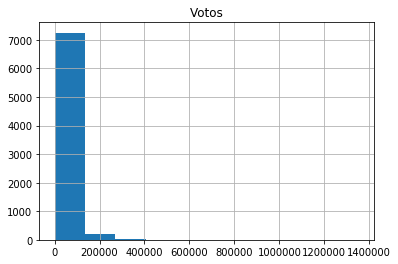

In [10]:
y.hist()
plt.title("Votos")
plt.show()

A partir do gráfico acima, que mostra a quantidade de candidatos (Y) que receberam a quantidade de votos (X), é possível perceber que os valores não seguem uma distribuição normal. Olhando de outra perspectiva, através de um boxplot, temos:

In [13]:
boxplot = go.Box(y=y)
plotly.iplot([boxplot])

Pelo boxplot acima fica evidente a suspeita de que existe um enorme número de outliers, estes recebendo uma quantidade de votos extremamente acima da média.

### Regressão Lasso

Inicialmente iremos definir alguns parâmetros para treinar diversas regressões Lasso, e assim definir qual o melhor conjunto de parâmetros para a mesma, tunando o Regresosr. Em seguida, podemos fazer uma comparação entre o regressor tunado e o regressor default, comparando o Erro Quadrático Médio (MSE) e a Raiz do Erro Quadrático Médio (RMSE).